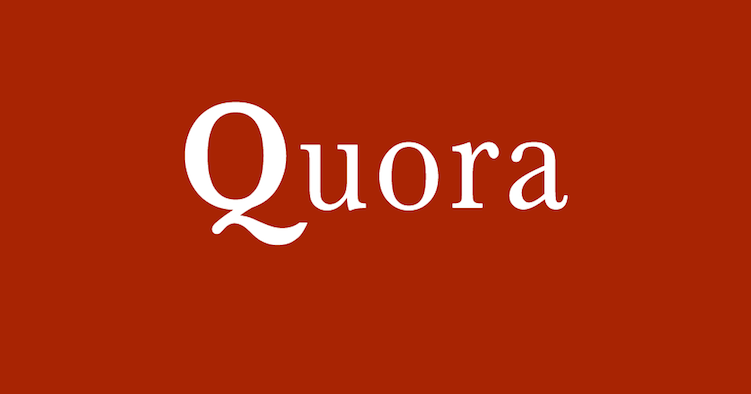

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

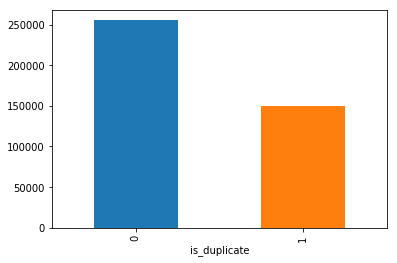

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



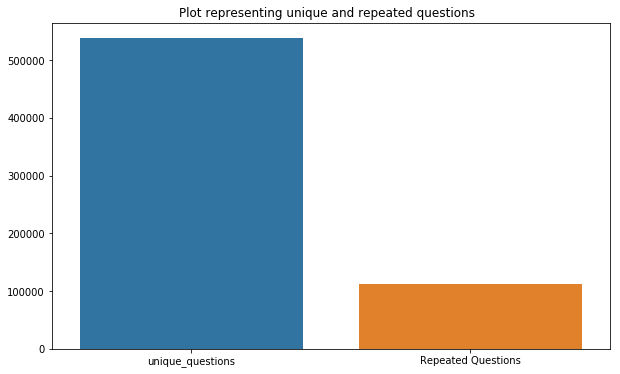

In [9]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [10]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



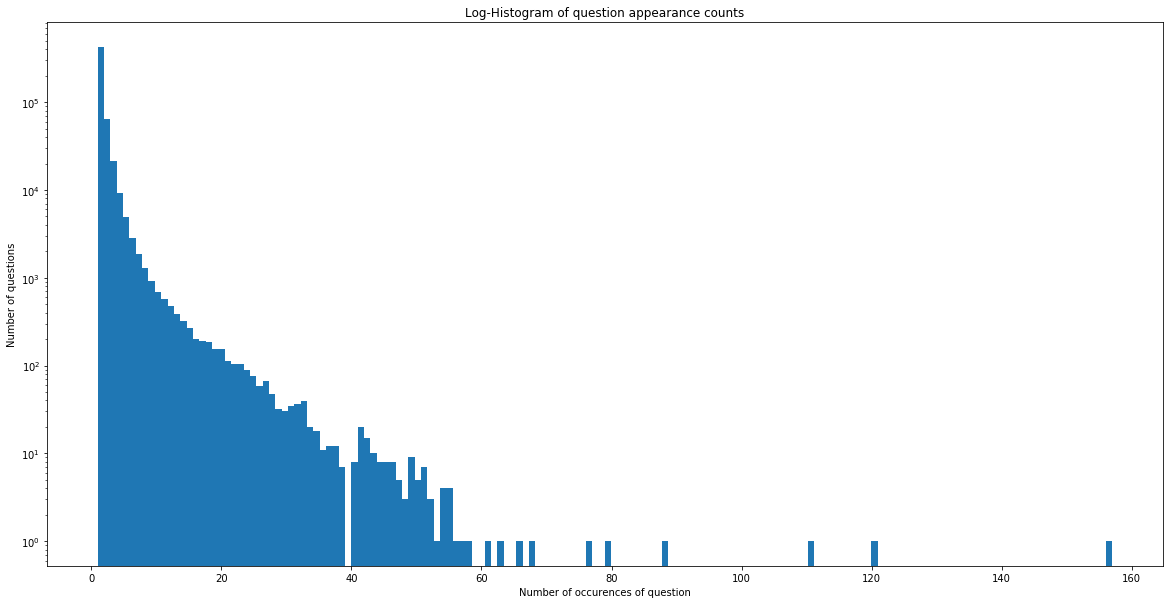

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [12]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [13]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [14]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [15]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


# We have extracted many features from our data, now we will plot each of the features against the 'is_duplicate' variable and check if we can get any insights.

<h4> Feature: q1len </h4>

C:\Users\kulkarni\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\kulkarni\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



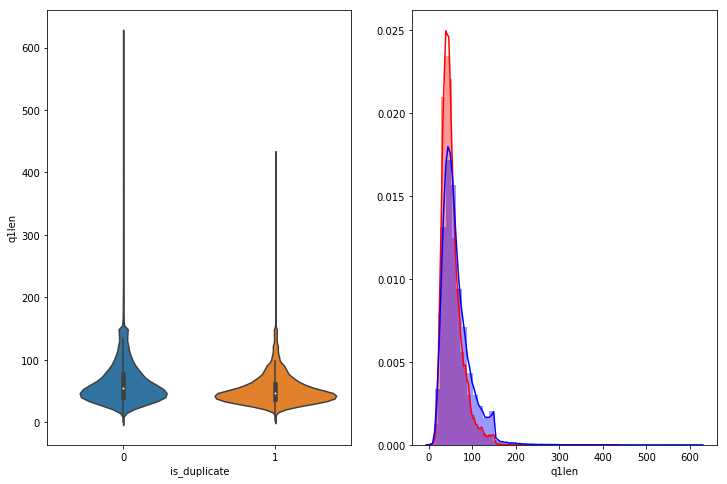

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'q1len', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['q1len'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q1len'][0:] , label = "0" , color = 'blue' )
plt.show()

# From the violin plot we can see that the length of question1 for the questions which are duplicate is a little less than
# the questions which are not duplicate. This is clear when we look at the quantiles from the violin plot.

<h4> Feature: q2len </h4>

C:\Users\kulkarni\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\kulkarni\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



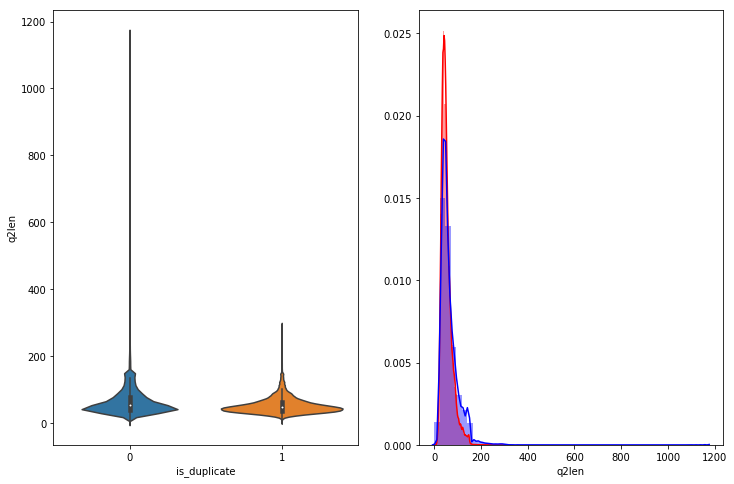

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'q2len', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['q2len'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q2len'][0:] , label = "0" , color = 'blue' )
plt.show()

# We get similar insights for 'question2' as for 'question1'

# From the violin plot we can see that the length of 'question2' for the questions which are duplicate is a little less than
# the questions which are not duplicate. This is clear when we look at the quantiles from the violin plot.

# From analyzing the above two features we can say that the length of questions when they are duplicate is smaller than when they are not duplicate.

<h4> Feature: q2_n_words </h4>

C:\Users\kulkarni\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\kulkarni\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



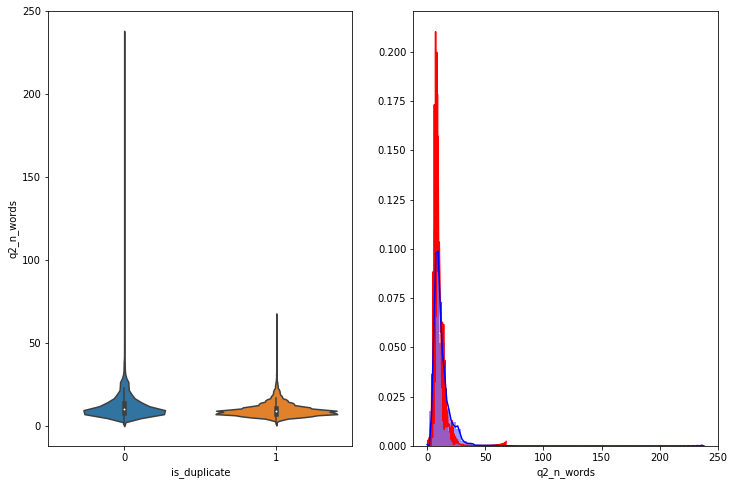

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'q2_n_words', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['q2_n_words'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q2_n_words'][0:] , label = "0" , color = 'blue' )
plt.show()


# From the violin plot we can see that the number of words in duplicate questions is less than number of words in 
# questions which are not duplicate

<h4> Feature: q1_n_words </h4>

C:\Users\kulkarni\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\kulkarni\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



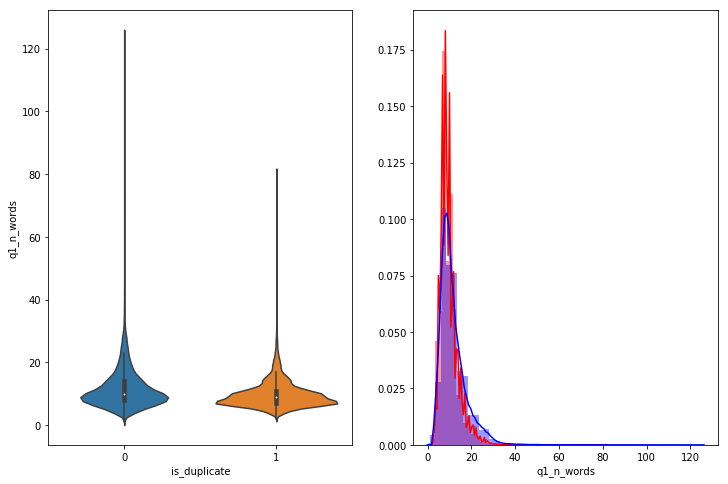

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'q1_n_words', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['q1_n_words'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['q1_n_words'][0:] , label = "0" , color = 'blue' )
plt.show()

# From the violin plot we can see that the number of words in duplicate questions is less than number of words in 
# questions which are not duplicate

# The number of words in both question1 and question2 are less when the questions are duplicate.

# This feature shows similar results to that of the length of questions features.

<h4>Feature: word_Total </h4>

C:\Users\kulkarni\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\kulkarni\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



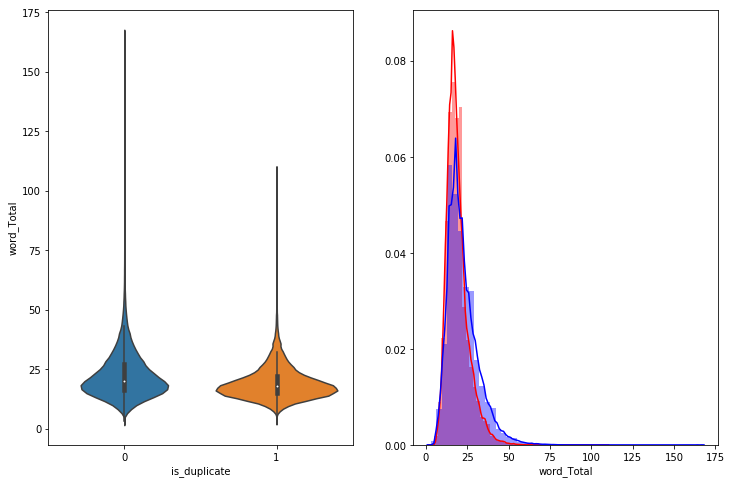

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Total', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Total'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Total'][0:] , label = "0" , color = 'blue' )
plt.show()

# From the word_Total feature we can say that the total number of words for duplicate questions are less than for non duplicate questions

<h4>Feature: word_share </h4>

C:\Users\kulkarni\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\kulkarni\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



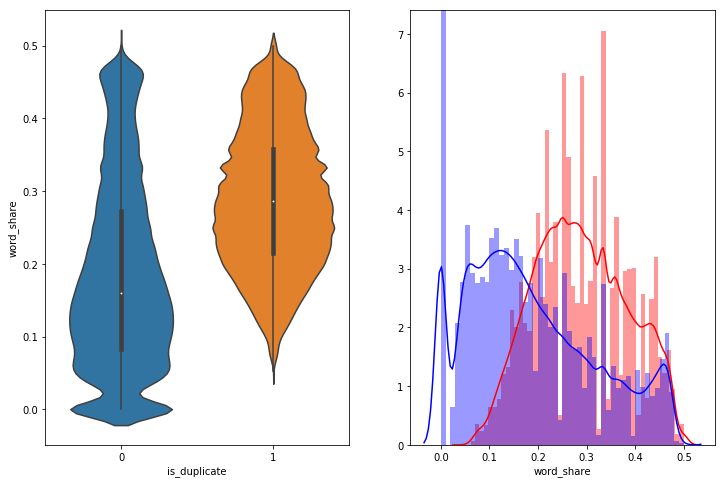

In [16]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> Feature: word_Common </h4>

C:\Users\kulkarni\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\kulkarni\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



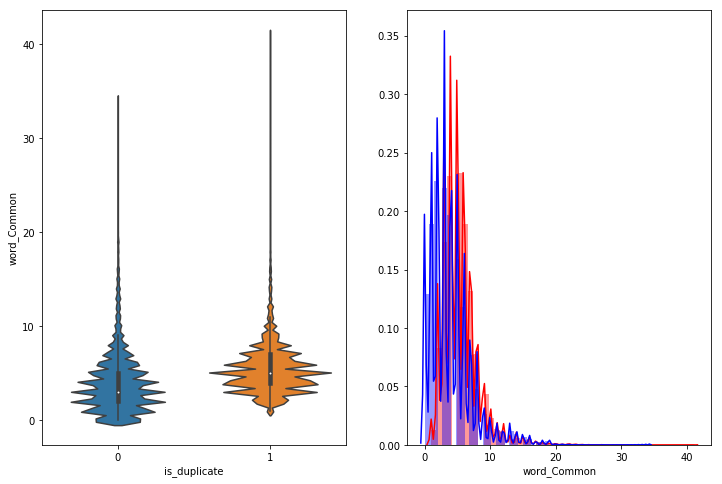

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

# 1.2.1 : EDA: Advanced Feature Extraction.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [25]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [26]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [27]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [28]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [29]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [24]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding="utf-8")
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding="utf-8")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [25]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt',),encoding="utf-8").read()
textn_w = open(path.join(d, 'train_n.txt'),encoding="utf-8").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


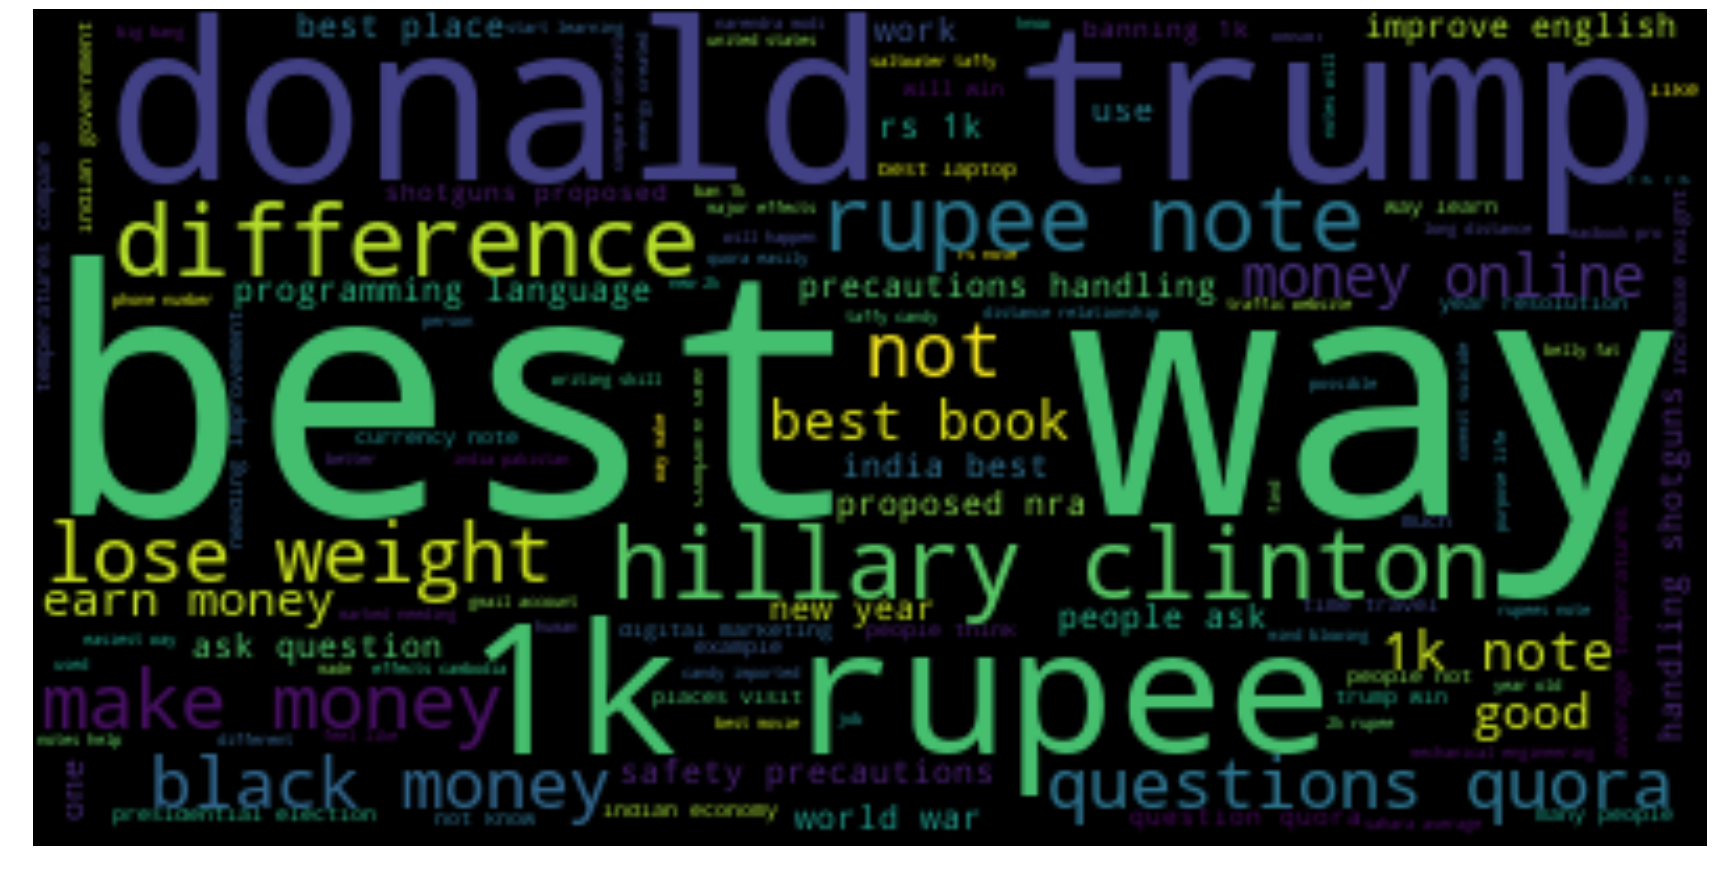

In [26]:
plt.figure(figsize=(30,20))
wc = WordCloud(background_color="black",max_font_size=100, max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


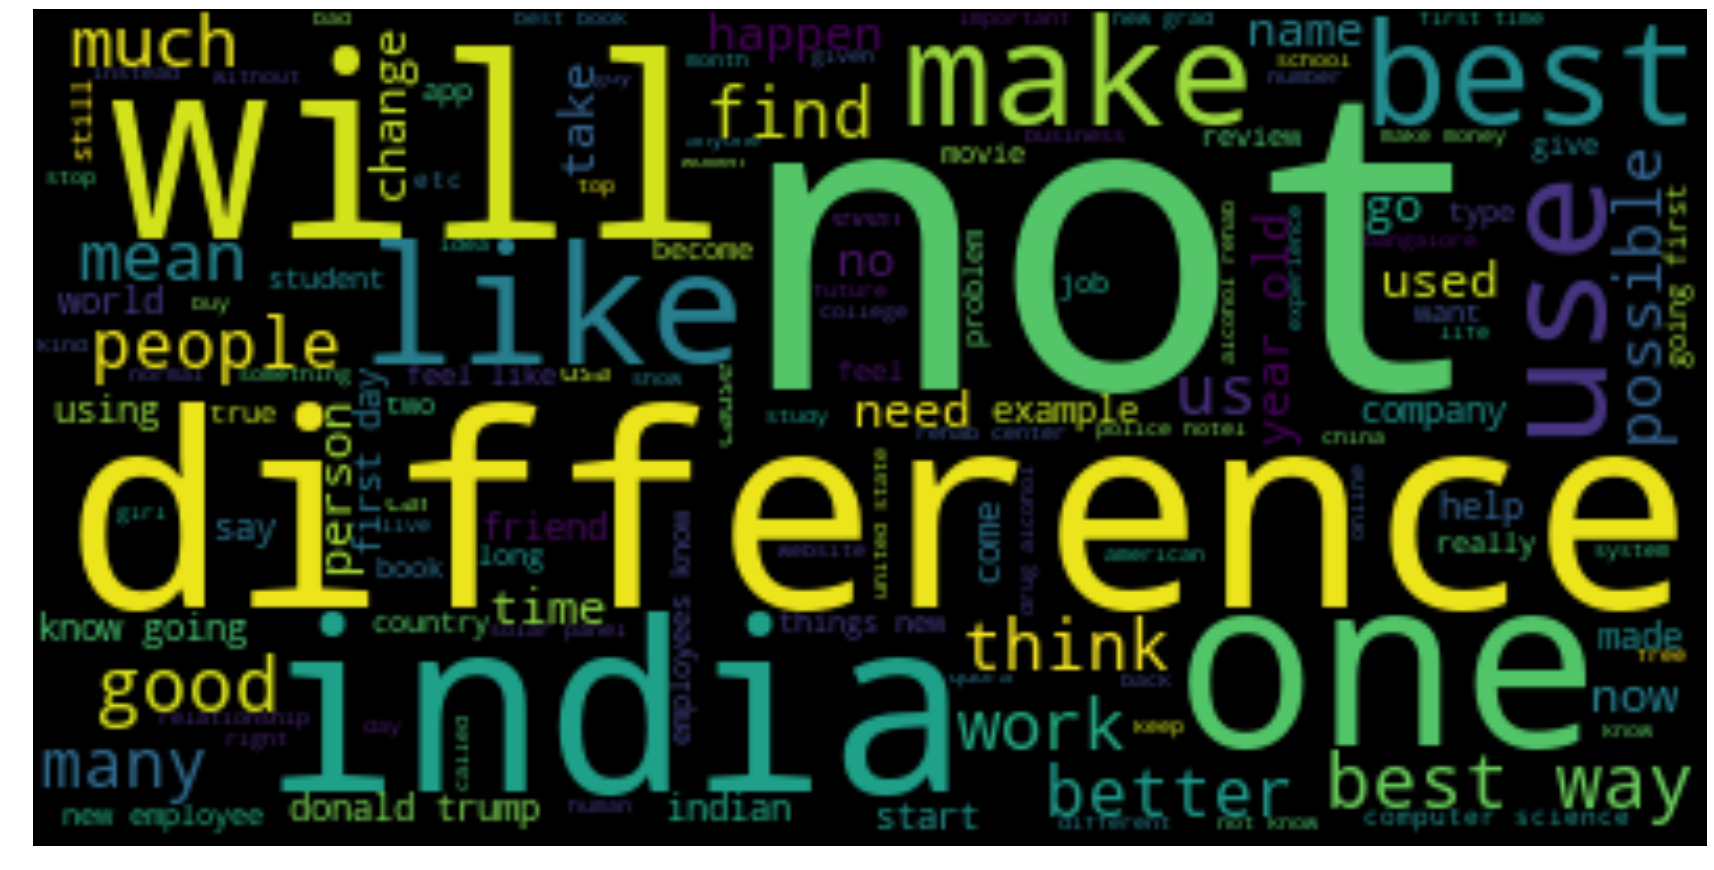

In [27]:
plt.figure(figsize=(30,20))
wc = WordCloud(background_color="black",max_font_size=100, max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

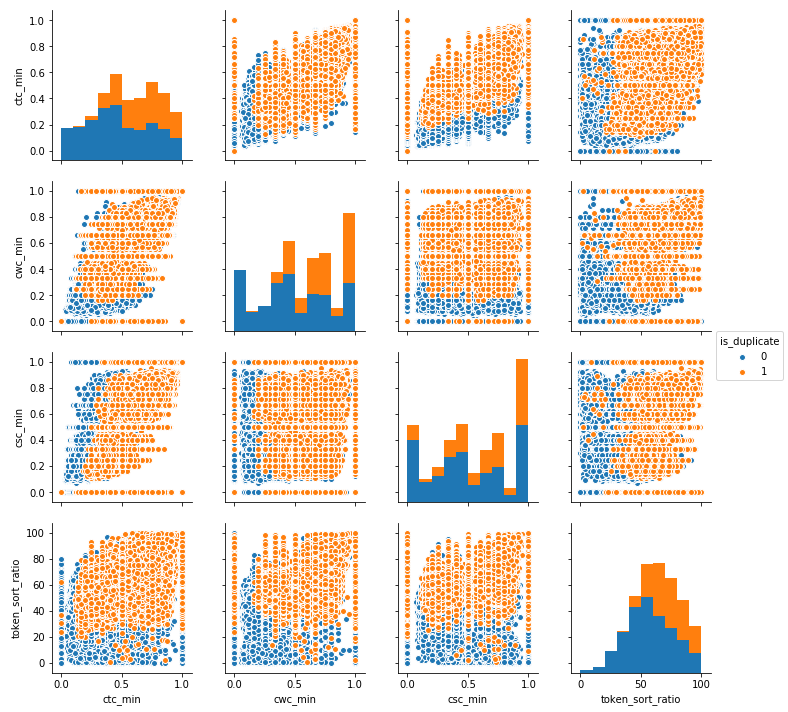

In [28]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

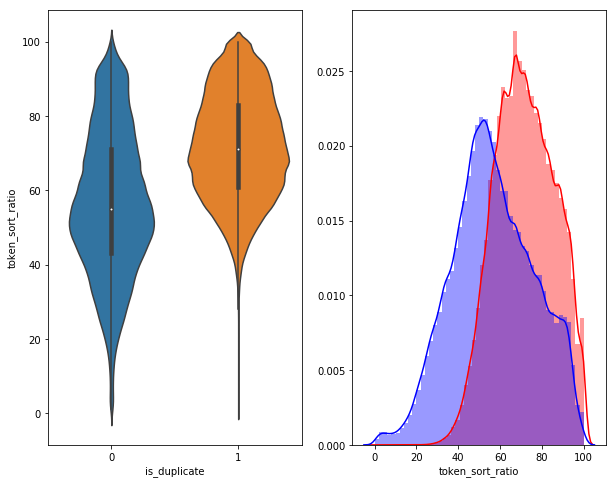

In [29]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

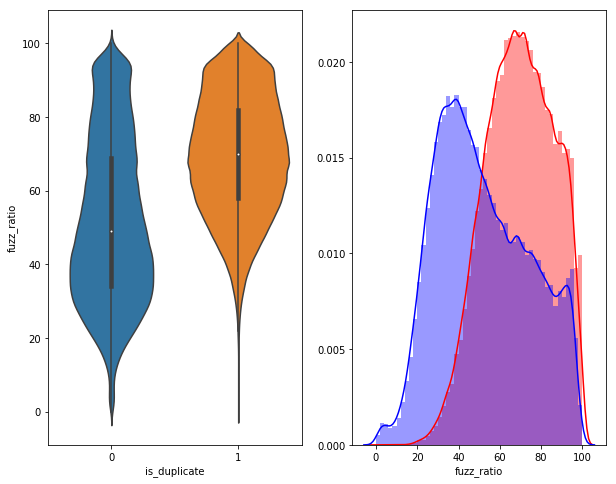

In [30]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h4> Feature: cwc_min </h4>

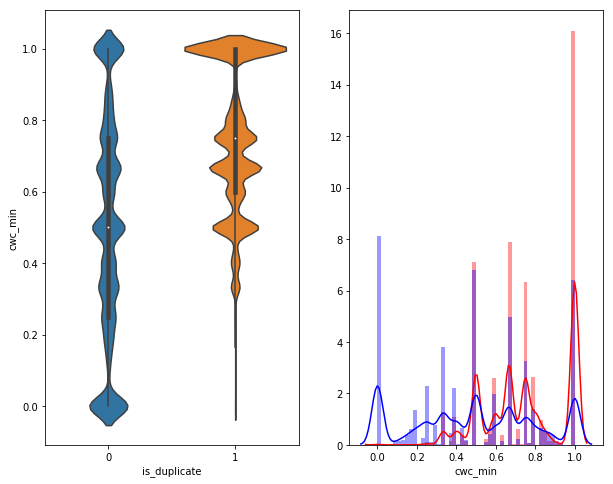

In [30]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'cwc_min', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['cwc_min'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['cwc_min'][0:] , label = "0" , color = 'blue' )
plt.show()

# We can see from the violin plot quantiles that the quantile values for the 'is_duplicate' variable are higher than the 
# quantiles for not duplicate.There is some information in the variable which would help us classify the question pairs as
# separate or not.

<h4> Feature: cwc_max </h4>

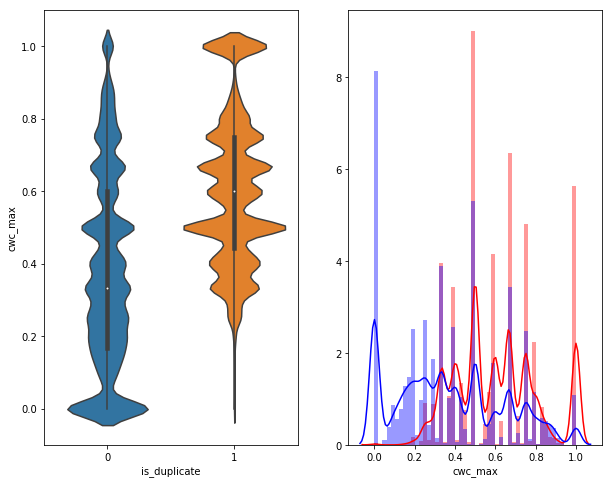

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'cwc_max', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['cwc_max'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['cwc_max'][0:] , label = "0" , color = 'blue' )
plt.show()

#From the 'cwc_max' variable violin plot we can estimate that the there is a difference between the distribution while predicting 
# whether the questions are duplicate and not duplicate.

<h4> Feature: csc_min </h4>

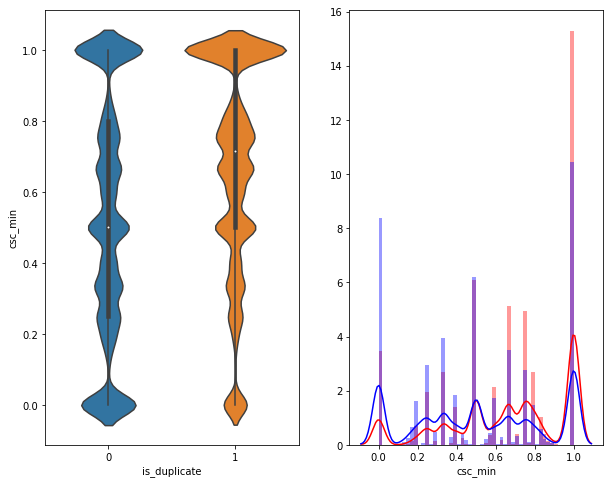

In [32]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'csc_min', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['csc_min'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['csc_min'][0:] , label = "0" , color = 'blue' )
plt.show()

# Depending upon the distribution of the 'csc_min' variable for the duplicate and not duplicate classification we can see
# that the variable will be useful based on the quantile values.

<h4> Feature: csc_max </h4>

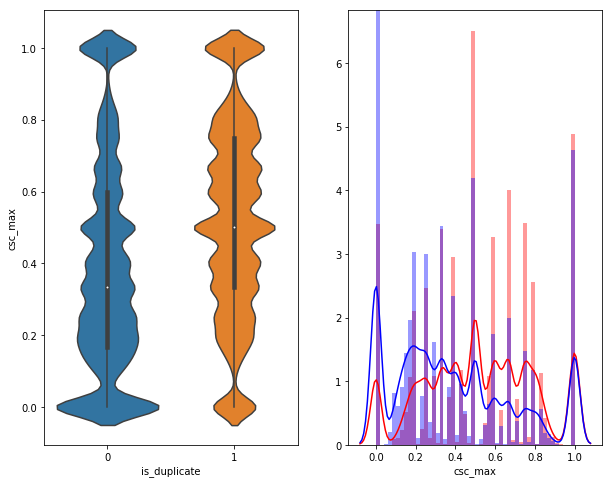

In [33]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'csc_max', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['csc_max'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['csc_max'][0:] , label = "0" , color = 'blue' )
plt.show()

# Depending upon the distribution of the 'csc_min' variable for the duplicate and not duplicate classification we can see
# that the variable will be useful based on the quantile values.

<h4> Feature: ctc_min </h4>

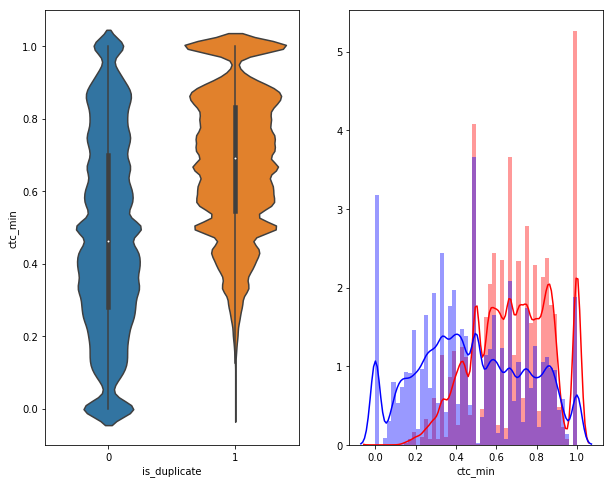

In [34]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'ctc_min', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['ctc_min'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['ctc_min'][0:] , label = "0" , color = 'blue' )
plt.show()

# From the violin plot as well as from the distribution plot against the 'is_duplicate' variable we can make out that 
# 'ctc_min' variable will be useful in predicting whether the question pairs are duplicate or not.

<h4> Feature: ctc_max </h4>

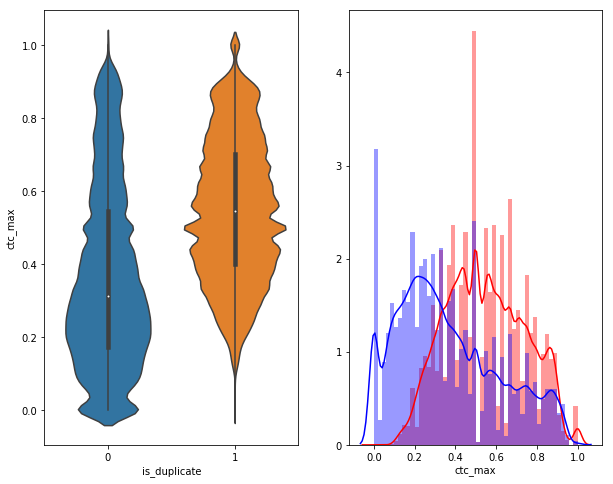

In [35]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'ctc_max', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['ctc_max'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['ctc_max'][0:] , label = "0" , color = 'blue' )
plt.show()

# From the violin plot as well as from the distribution plot against the 'is_duplicate' variable we can make out that 
# 'ctc_max' variable will be useful in predicting whether the question pairs are duplicate or not.

<h4> Feature: fuzz_partial_ratio </h4>

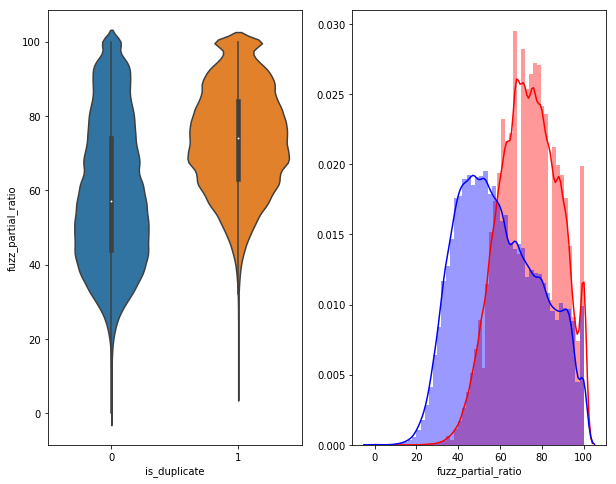

In [37]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

# From the violin plot as well as from the distribution plot against the 'is_duplicate' variable we can make out that 
# 'fuzz_partial_ratio' variable will be useful in predicting whether the question pairs are duplicate or not.

<h4> Feature: token_set_ratio </h4>

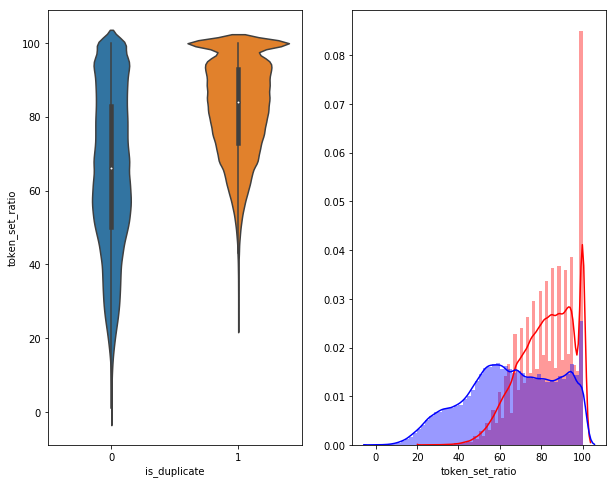

In [39]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

# From the violin plot as well as from the distribution plot against the 'is_duplicate' variable we can make out that 
# 'token_set_ratio' variable will be useful in predicting whether the question pairs are duplicate or not.

<h3>3.5.2 Visualization </h3>

In [31]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [32]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.114s...
[t-SNE] Computed neighbors for 5000 samples in 0.516s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.322s
[t-SNE] Iteration 50: error = 81.2897949, gradient norm = 0.0455700 (50 iterations in 11.032s)
[t-SNE] Iteration 100: error = 70.6164398, gradient norm = 0.0095177 (50 iterations in 7.401s)
[t-SNE] Iteration 150: error = 68.9172134, gradient norm = 0.0056736 (50 iterations in 7.162s)
[t-SNE] Iteration 200: error = 68.1004639, gradient norm = 0.0049672 (50 iterations in 7.217s)
[t-SNE] Iteration 250: error = 67.5914536, gradient norm = 0.003970

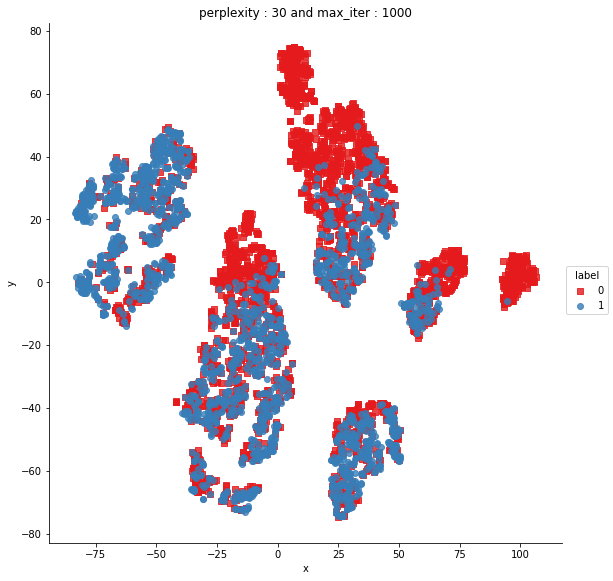

In [33]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [34]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 0.478s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.289s
[t-SNE] Iteration 50: error = 80.5298615, gradient norm = 0.0306586 (50 iterations in 18.235s)
[t-SNE] Iteration 100: error = 69.3777008, gradient norm = 0.0037944 (50 iterations in 8.561s)
[t-SNE] Iteration 150: error = 67.9726028, gradient norm = 0.0017517 (50 iterations in 7.969s)
[t-SNE] Iteration 200: error = 67.4098892, gradient norm = 0.0013384 (50 iterations in 8.019s)
[t-SNE] Iteration 250: error = 67.0977859, gradient norm = 0.000959

In [ ]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy
import en_core_web_sm

In [2]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [10]:
len(doc1[0].vector)

96

In [11]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm')
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|████████████████████████████████| 404290/404290 [1:22:07<00:00, 82.05it/s]


In [12]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████| 404290/404290 [1:25:49<00:00, 78.52it/s]


In [13]:
# Checking the first few rows of the df dataset:

df.head(3)
# We can see the tfidf weghted w2vec of feature1 and feature2

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[211.12987351417542, -144.68305438756943, -68....","[151.26853108406067, -127.01317399740219, -31...."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[144.1246476173401, -114.01248480379581, -111....","[152.02307403087616, -44.95535599440336, -103...."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[81.75786409899592, -142.1845142841339, 0.5598...","[4.930252477526665, -29.02956795692444, -117.8..."


In [24]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [61]:
#df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
#df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
#df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
#df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index,columns=list(range(99,195)))

In [5]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [6]:
# 'dropping the is_duplicate column from the dataset'

df1 = df1.drop(['is_duplicate'],axis=1)

In [7]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [15]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,211.129874,-144.683054,-68.811249,-153.662109,-89.931611,2.311274,136.743697,50.449099,-64.150947,56.627538,...,33.176600,-102.487000,144.595707,50.614258,-21.385909,36.385574,-70.999801,4.141482,-131.379516,71.884578
1,144.124648,-114.012485,-111.716660,-104.885020,-88.238451,16.441811,58.238055,102.095074,6.026957,178.498576,...,67.386258,22.131793,40.210763,0.254038,98.600218,-36.436028,-123.609746,71.788323,-15.374581,-10.503989
2,81.757864,-142.184514,0.559871,-104.660074,-84.156632,22.515128,115.521672,50.436953,-111.740921,51.713283,...,61.731843,-49.822509,107.080585,-11.431460,-40.667738,-26.771835,-12.482051,1.764692,-100.330469,148.061182
3,-126.651898,-59.747152,-67.763228,-138.114753,-101.038727,88.148521,-22.912262,85.941433,27.784232,50.810635,...,117.847438,-13.044566,-1.643150,78.158391,23.748121,12.946001,-8.807328,123.360072,64.057073,-24.943291
4,299.444034,-188.631994,-22.946243,-273.683356,-188.480359,107.123026,174.946275,-72.042302,-98.290455,137.440024,...,62.256722,-173.503653,249.320188,27.972500,-26.665015,-28.469178,-62.335420,2.738913,-120.762608,111.779830


In [62]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,99,100,101,102,103,104,105,106,107,108,...,185,186,187,188,189,190,191,192,193,194
0,151.268531,-127.013174,-31.546291,-142.905781,-97.249108,9.485730,106.682230,36.754153,-36.541901,53.162223,...,28.763412,-108.306629,131.115580,42.530930,-14.726201,15.763613,-59.729559,-9.563372,-99.812548,57.643640
1,152.023074,-44.955356,-103.559248,-128.467540,-118.567592,44.577929,137.906209,26.984688,-78.328355,86.576884,...,117.588041,5.239813,56.622434,92.054098,141.063333,-30.466213,-25.418968,87.120071,-23.594480,7.936897
2,4.930252,-29.029568,-117.808777,-98.332260,-19.064157,-9.867785,141.808178,91.269573,50.727237,12.816821,...,128.699924,17.433380,58.203355,88.642943,-84.962801,71.462319,-10.853905,-59.501689,-99.425307,95.334793
3,-6.951958,-44.951737,-17.343058,-61.444457,-7.469162,16.941943,95.049226,-2.631614,-13.050928,-28.038384,...,70.475263,-31.174242,86.080270,49.967749,25.750421,-27.612360,24.050787,-3.504155,-46.115806,56.242263
4,96.174529,-71.613957,21.584909,-92.742441,-106.643132,10.646803,92.190119,-40.565991,-34.739529,56.340503,...,18.852802,-70.416546,87.693583,38.386026,-14.003126,-12.975115,46.318854,-25.159628,-53.098672,-2.351899


In [8]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
#print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
#print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
#print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])


Number of features in nlp dataframe : 16
Number of features in preprocessed dataframe : 12


# Was going to run the whole project first and then start with the assignment but, I am getting a memory error while running the cell below and hence cannot write the to the 'final_features.csv' file.

# Will start with the assignment from this stage.

In [9]:
# storing the final features to csv file
#if not os.path.isfile('final_features.csv'):
#    df3_q1['id']=df1['id']
#    df3_q2['id']=df1['id']
#    df1  = df1.merge(df2, on='id',how='left')
#    df2  = df3_q1.merge(df3_q2, on='id',how='left')
#    result  = df1.merge(df2, on='id',how='left')
#    result.to_csv('final_features.csv')

# We will have to perform the following operations to get our dataframe of final features which would consists of basic features, advanced features and tfidf text features

# We have three dataframes from which we will be able to extract our final features



In [25]:
# We will be merging the dataframe df1 with the basic features from dfppro dataframe

df_basic = dfppro.drop(['qid1','qid2','is_duplicate'],axis=1)

In [26]:
# Taking a look at the first few lines of our df_basic dataframe

df_basic.head()

# We can see that the basic features have been extracted
# Now we will merge these features with the advanced features

,id,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [29]:
df_basic_advanced = df_basic.merge(df1, on = 'id', how = 'left')

In [30]:
# Taking a look at the shape of the data

df_basic_advanced.shape

# We can see we have 39 features after combining the basic and advanced features.

(404290, 30)

In [31]:
# Checking the first few rows of our combined dataframe consisting of the basic and advanced features

df_basic_advanced.head(3)

,id,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,4,1,51,88,8,13,4.0,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,1,1,73,59,14,10,4.0,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667


In [32]:
df_basic_advanced.columns

Index(['id', 'question1', 'question2', 'freq_qid1', 'freq_qid2', 'q1len',
       'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       'word_share', 'freq_q1+q2', 'freq_q1-q2', 'is_duplicate', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

In [39]:
df_ba_tfidfw2vec = df_basic_advanced.drop(['is_duplicate'], axis = 1)

In [42]:
df_ba_tfidfw2vec.columns

Index(['id', 'question1', 'question2', 'freq_qid1', 'freq_qid2', 'q1len',
       'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

In [63]:
#df3_q1['id'] = df_basic_advanced['id']
df3_q2['id'] = df_basic_advanced['id']

In [46]:
df3_q1.columns

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
         24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
         36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
         48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
         60,   61,   62,   63,   64,   65,   66,   67,   68,   69,   70,   71,
         72,   73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,
         84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,   95,
       'id'],
      dtype='object')

In [64]:
df3_q2.columns

Index([  99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,  122,
        123,  124,  125,  126,  127,  128,  129,  130,  131,  132,  133,  134,
        135,  136,  137,  138,  139,  140,  141,  142,  143,  144,  145,  146,
        147,  148,  149,  150,  151,  152,  153,  154,  155,  156,  157,  158,
        159,  160,  161,  162,  163,  164,  165,  166,  167,  168,  169,  170,
        171,  172,  173,  174,  175,  176,  177,  178,  179,  180,  181,  182,
        183,  184,  185,  186,  187,  188,  189,  190,  191,  192,  193,  194,
       'id'],
      dtype='object')

In [67]:
# Now merging the tfidfw2vec features of question1 and question2 w/ df_basic_advanced based on id:
data_final = df_ba_tfidfw2vec.merge(df3_q1, on='id', how='left')
data_final1 = data_final.merge(df3_q2, on='id', how='left')

In [69]:
# Checking shape:
data_final1.shape

(404290, 221)

In [70]:
# Dropping the columns id, question1 and question2:

data_final_tfidfw2vec = data_final1.drop(['id','question1','question2'],axis=1)
data_final_tfidfw2vec.shape

(404290, 218)

In [71]:
# We will divide our combined data of basic and advanced features into train and test sets

# Setting the target variable before dividing our data into train and test sets
target = dfppro['is_duplicate']


In [16]:
# Now splitting the data into train and test sets

# We will now divide the data into train and test sets
# The split will be 70:30 as train and test respectively
# Importing the library required to split the data
from sklearn.model_selection import train_test_split

x_train_ba,x_test_ba, y_train, y_test = train_test_split(df_basic_advanced, target, test_size=0.3)

In [17]:
# Taking a look at the train and test shapes of our data

print("Number of data points in train data :",x_train_ba.shape)
print("Number of data points in test data :",x_test_ba.shape)

Number of data points in train data : (283003, 29)
Number of data points in test data : (121287, 29)


In [19]:
# Now we will vectorize the question1 and question2 features using TF-IDF vectorizer.
# Before that let us check the dimensions of the question1 and question2 belonging to train and test sets.

# Checking for question1
print('For question 1:')
print(x_train_ba['question1'].shape)
print(x_test_ba['question1'].shape)
print()
print("-----------------------------")
print()
# Checking for question2
print('For question 2:')
print(x_train_ba['question2'].shape)
print(x_test_ba['question2'].shape)

For question 1:
(283003,)
(121287,)

-----------------------------

For question 2:
(283003,)
(121287,)


In [59]:
# Now we will vectorize the question1 and question2:

# Importing the required libraries:
from sklearn.feature_extraction.text import TfidfVectorizer

# "question1" feature
tfidf_vectorize_q1 = TfidfVectorizer()

x_trainq1_dtm = tfidf_vectorize_q1.fit_transform(x_train_ba['question1'].values.astype('U'))
x_testq1_dtm = tfidf_vectorize_q1.transform(x_test_ba['question1'].values.astype('U'))

In [60]:
# Vectorizing the 'question2' feature:

tfidf_vectorize_q2 = TfidfVectorizer()

x_trainq2_dtm = tfidf_vectorize_q2.fit_transform(x_train_ba['question2'].values.astype('U'))
x_testq2_dtm = tfidf_vectorize_q2.transform(x_test_ba['question2'].values.astype('U'))

In [61]:
# Now we will stack the train and test data of question1 and question2

from scipy.sparse import hstack

# Train features
qu1_qu2_train = hstack((x_trainq1_dtm,x_trainq2_dtm))

# Test features
qu1_qu2_test = hstack((x_testq1_dtm,x_testq2_dtm))

In [62]:
# Before stacking all the features we will drop the question1 and question2 features from the basic_advanced dataframe:
# Checking the first few rows once:

print('Train Data:')
x_train_ba.head(2)

Train Data:


,id,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
272695,272695,Are the forces of supply and demand on gold an...,How is the price of gold determined in India?,1,3,67,45,12,9,3.0,...,0.249998,0.0,0.0,3.0,10.5,42,44,45,43,0.130435
308696,308696,What is the history behind the Masterson House?,"How and when did the name ""India"" come into use?",1,5,47,48,8,10,1.0,...,0.099999,0.0,0.0,2.0,9.0,46,42,39,44,0.125000


In [63]:
# Dropping the question1 and question2 features for the train data:

x_train_ba1 = x_train_ba.drop(['id','question1','question2'],axis=1)
# Checking for columns
x_train_ba1.head(1)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
272695,1,3,67,45,12,9,3.0,20.0,0.15,4,...,0.249998,0.0,0.0,3.0,10.5,42,44,45,43,0.130435


In [64]:
print('Test Data:')
x_test_ba.head(2)

Test Data:


,id,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
168225,168225,How many questions can I solve in the biology ...,Is the NCERT enough for the AIPMT biology entr...,1,1,84,136,16,25,13.0,...,0.559998,1.0,0.0,9.0,20.5,97,74,67,94,0.611765
23915,23915,Telugu Film Industry: What you hate the most a...,Who is A1 star in telugu?,1,1,73,25,12,6,1.0,...,0.166665,0.0,0.0,6.0,9.0,63,44,12,44,0.269231


In [65]:
x_test_ba1 = x_test_ba.drop(['id','question1','question2'],axis=1)
# Checking for columns
x_test_ba1.head(1)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
168225,1,1,84,136,16,25,13.0,35.0,0.371429,2,...,0.559998,1.0,0.0,9.0,20.5,97,74,67,94,0.611765


In [66]:
# Stacking all the train features together

X_train_final = hstack((x_train_ba1,qu1_qu2_train))

In [67]:
# Stacking all the test features together

x_test_final = hstack((x_test_ba1,qu1_qu2_test))

In [68]:
# Checking the shapes of our data before applying our machine learning models

print("Number of data points in train data :",X_train_final.shape)
print("Number of data points in test data :",x_test_final.shape)

Number of data points in train data : (283003, 111129)
Number of data points in test data : (121287, 111129)


In [69]:
# Checking the shape of our target variable

print("Number of data points in train data :",y_train.shape[0])
print("Number of data points in test data :",y_test.shape[0])

Number of data points in train data : 283003
Number of data points in test data : 121287


In [70]:
X_train_final

<283003x111129 sparse matrix of type '<class 'numpy.float64'>'
	with 12326381 stored elements in COOrdinate format>

In [71]:
# Now we will standardize the data 

# Importig the libraries required to standardize the data
from sklearn.preprocessing import StandardScaler

# Scaling our train as well as test data
# Fitting the scalar to our train data and transforming the train as well as test datasets

scaler = StandardScaler(with_mean= False)
X_train_final_std = scaler.fit_transform(X_train_final)
X_test_final_std = scaler.transform(x_test_final)
#X_train_std_final = scaler.transform(X_train_final) # Train data
#X_test_std_final = scaler.transform(X_test_final) # Test data

# Here we will be applying our ML models 

In [72]:
# Importing the libraries required for creating the models

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# Creating a function to plot our Confusion, Precision and Recall matrix

In [56]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Applying the ML models 

# Creating a Random Model

Log loss on Test Data using Random Model 0.8790834955397047


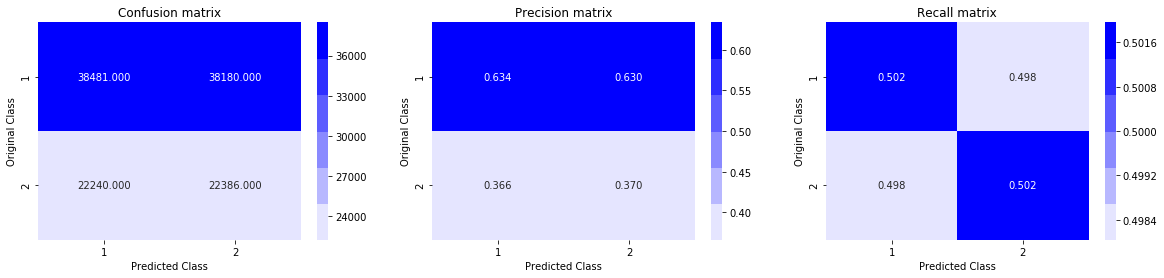

In [41]:
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# We can see that the test log loss for the random model is 0.87908

# Creating a Logisitc Regression Model with Hyperparameter tuning using Tf-Idf text features

For values of alpha =  1e-06 The log loss is: 0.5316311240529764
For values of alpha =  1e-05 The log loss is: 0.5324505452266021
For values of alpha =  0.0001 The log loss is: 0.5314405815144888
For values of alpha =  0.001 The log loss is: 0.5324473980484603
For values of alpha =  0.01 The log loss is: 0.49001444513448306
For values of alpha =  0.1 The log loss is: 0.41826505837664185
For values of alpha =  1 The log loss is: 0.4309375675946111
For values of alpha =  10 The log loss is: 0.45141468285402064
For values of alpha =  100 The log loss is: 0.45546454264217556


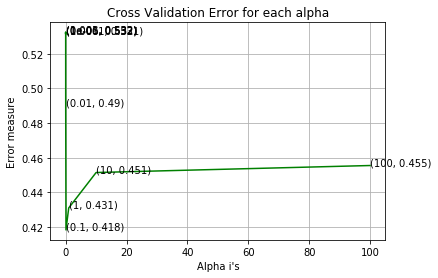

For values of best alpha =  0.1 The train log loss is: 0.3252436371073975
For values of best alpha =  0.1 The test log loss is: 0.4215408491636984
Total number of data points : 121287


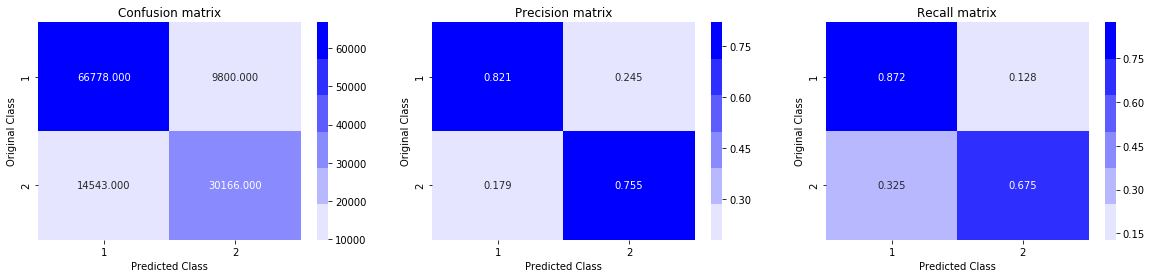

In [76]:

alpha = [10 ** x for x in range(-6, 3)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, class_weight= 'balanced')
    clf.fit(X_train_final_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv =3)
    sig_clf.fit(X_train_final_std, y_train)
    predict_y = sig_clf.predict_proba(X_test_final_std)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_final_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv =3 )
sig_clf.fit(X_train_final_std, y_train)

predict_y = sig_clf.predict_proba(X_train_final_std)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# We can see that the minimum test log loss for the Logistic Regression model is 0.421

# Creating a Linear SVM Model with Hyperparameter tuning using Tf-Idf text features

For values of alpha =  1e-06 The log loss is: 0.5493562875441962
For values of alpha =  1e-05 The log loss is: 0.5466581073923574
For values of alpha =  0.0001 The log loss is: 0.5669810342054281
For values of alpha =  0.001 The log loss is: 0.6185226167497354
For values of alpha =  0.01 The log loss is: 0.6541083066333201
For values of alpha =  0.1 The log loss is: 0.6581687320141589
For values of alpha =  1 The log loss is: 0.6582086808574766
For values of alpha =  10 The log loss is: 0.6581971287422803


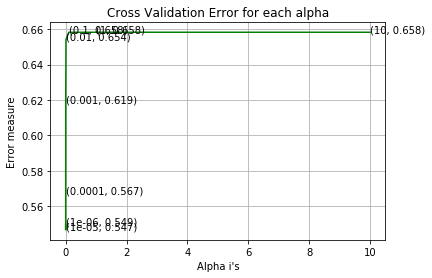

For values of best alpha =  1e-05 The train log loss is: 0.49131213803620066
For values of best alpha =  1e-05 The test log loss is: 0.5439224669884414
Total number of data points : 121287


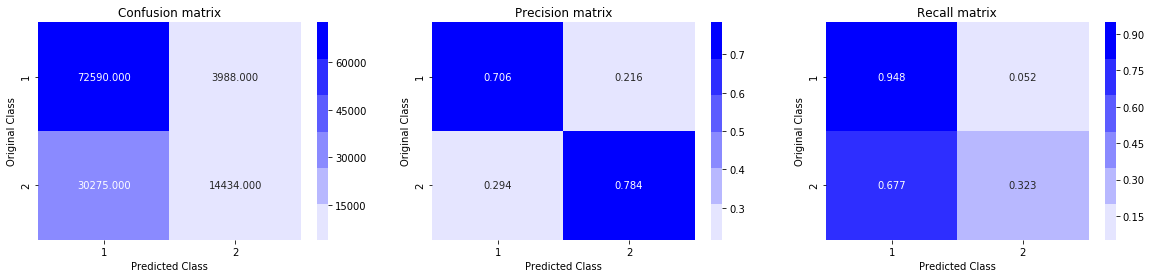

In [75]:
alpha = [10 ** x for x in range(-6, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, class_weight= 'balanced')
    clf.fit(X_train_final_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final_std, y_train)
    predict_y = sig_clf.predict_proba(X_test_final_std)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_final_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final_std, y_train)

predict_y = sig_clf.predict_proba(X_train_final_std)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


# We can see that the minimum test log loss for Linear SVM model is 0.543.

# Creating an XgBoost Model with Randomized Search for hyperparameter tuning using Tf-Idf text features

In [72]:
# Dividing the data into train and test sets based on tfidfw2vec for our xgboost model:

from sklearn.model_selection import train_test_split

x_train_batfidfw2vec,x_test_batfidfw2vec, y_train, y_test = train_test_split(data_final_tfidfw2vec, target, test_size=0.3)

In [74]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
#import scipy.stats as st

In [77]:
# Setting the parameters to create our model

parameter_grid = {
    'silent': [False],
    'max_depth': [4,6,8],
    'n_estimators': [100,300,500],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

fit_parameter = {
    'eval_metric': 'logloss',
    'early_stopping_rounds': 10,
    'eval_set': [(x_train_batfidfw2vec, y_train)]
}

In [78]:
# Initializing our xgboost classifier

xgb_clf = xgb.XGBClassifier()

In [79]:
# Initializing randomized search classifier

rsc_xgb_clf = RandomizedSearchCV(xgb_clf,parameter_grid,n_jobs=-1,cv = 3, fit_params=fit_parameter,scoring='neg_log_loss',
                                 random_state=42)

In [80]:
# Fitting our randomized search classifier to the data

rsc_xgb_clf.fit(x_train_batfidfw2vec, y_train)

[0]	validation_0-logloss:0.655849
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.629451
[2]	validation_0-logloss:0.60612
[3]	validation_0-logloss:0.577344
[4]	validation_0-logloss:0.552753
[5]	validation_0-logloss:0.530121
[6]	validation_0-logloss:0.511398
[7]	validation_0-logloss:0.496409
[8]	validation_0-logloss:0.483067
[9]	validation_0-logloss:0.471515
[10]	validation_0-logloss:0.46052
[11]	validation_0-logloss:0.450768
[12]	validation_0-logloss:0.442783
[13]	validation_0-logloss:0.434556
[14]	validation_0-logloss:0.427456
[15]	validation_0-logloss:0.419882
[16]	validation_0-logloss:0.414718
[17]	validation_0-logloss:0.409186
[18]	validation_0-logloss:0.404481
[19]	validation_0-logloss:0.399742
[20]	validation_0-logloss:0.396611
[21]	validation_0-logloss:0.391967
[22]	validation_0-logloss:0.388293
[23]	validation_0-logloss:0.38538
[24]	validation_0-logloss:0.381925
[25]	validation_0-logloss:0.379946
[26]	validation_0-logloss:0.377631


[230]	validation_0-logloss:0.290567
[231]	validation_0-logloss:0.290406
[232]	validation_0-logloss:0.290172
[233]	validation_0-logloss:0.290032
[234]	validation_0-logloss:0.289822
[235]	validation_0-logloss:0.289563
[236]	validation_0-logloss:0.289337
[237]	validation_0-logloss:0.289229
[238]	validation_0-logloss:0.289053
[239]	validation_0-logloss:0.288893
[240]	validation_0-logloss:0.288631
[241]	validation_0-logloss:0.288461
[242]	validation_0-logloss:0.288234
[243]	validation_0-logloss:0.288033
[244]	validation_0-logloss:0.287905
[245]	validation_0-logloss:0.287731
[246]	validation_0-logloss:0.287636
[247]	validation_0-logloss:0.287549
[248]	validation_0-logloss:0.287437
[249]	validation_0-logloss:0.2873
[250]	validation_0-logloss:0.287172
[251]	validation_0-logloss:0.286929
[252]	validation_0-logloss:0.286777
[253]	validation_0-logloss:0.286541
[254]	validation_0-logloss:0.286319
[255]	validation_0-logloss:0.286117
[256]	validation_0-logloss:0.286011
[257]	validation_0-logloss:0.2

[459]	validation_0-logloss:0.25598
[460]	validation_0-logloss:0.255837
[461]	validation_0-logloss:0.255753
[462]	validation_0-logloss:0.255604
[463]	validation_0-logloss:0.255526
[464]	validation_0-logloss:0.255422
[465]	validation_0-logloss:0.255238
[466]	validation_0-logloss:0.255041
[467]	validation_0-logloss:0.254974
[468]	validation_0-logloss:0.254917
[469]	validation_0-logloss:0.254827
[470]	validation_0-logloss:0.254691
[471]	validation_0-logloss:0.254583
[472]	validation_0-logloss:0.254498
[473]	validation_0-logloss:0.254388
[474]	validation_0-logloss:0.254298
[475]	validation_0-logloss:0.254117
[476]	validation_0-logloss:0.254046
[477]	validation_0-logloss:0.253942
[478]	validation_0-logloss:0.253751
[479]	validation_0-logloss:0.253648
[480]	validation_0-logloss:0.25355
[481]	validation_0-logloss:0.253521
[482]	validation_0-logloss:0.253438
[483]	validation_0-logloss:0.253358
[484]	validation_0-logloss:0.253178
[485]	validation_0-logloss:0.253041
[486]	validation_0-logloss:0.2

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
          fit_params={'eval_metric': 'logloss', 'early_stopping_rounds': 10, 'eval_set': [(        freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
202602          1          4     35     25           7           5
269503          3          6     45     80           9          15
48396    ...
196462    1
381040    0
51082     1
273524    0
Name: is_duplicate, Length: 283003, dtype: int64)]},
          iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'silent':

In [81]:
# Extracting the best parameters from our model

print(rsc_xgb_clf.best_params_)

{'subsample': 0.9, 'silent': False, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7}


In [83]:
# Now that we have found our best parameters we will find the test log loss

xgb_clf_final = xgb.XGBClassifier(max_depth=6,learning_rate=0.1,n_estimators=500,silent=False,
                                  colsample_bytree=0.5, colsample_bylevel=0.7)

In [86]:
# We will now fit the classifier to our train and test data
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
cal_clf = CalibratedClassifierCV(xgb_clf_final, method='sigmoid', cv = 3)
cal_clf.fit(x_train_batfidfw2vec,y_train)
predict_y = cal_clf.predict_proba(x_test_batfidfw2vec)
log_loss(y_test, predict_y, eps=1e-15)
print("The log loss is:",log_loss(y_test, predict_y,  eps=1e-10))

The log loss is: 0.3291892131242109


# We can see that the log loss on the test data for our xgboost model is 0.000021 which is great performance compared to our previous models.

# Creating a table of our results

In [89]:
import prettytable
from prettytable import PrettyTable

list1 = ['Random Model','Logistic Regression','Linear SVM','XGBoost with hyperparameters']
list2 = ['-','TF-IDF','TF-IDF','TFIDF-W2Vec']
list3 = ['0.88473','0.421','0.543','0.329']


print('The scores for the different models are:')
table = PrettyTable(['Classifier Type','Vectorizer','Test Log Loss'])
for x in range(0,4):
    table.add_row([list1[x],list2[x],list3[x]])
                                       
print(table) 

The scores for the different models are:
+------------------------------+-------------+---------------+
|       Classifier Type        |  Vectorizer | Test Log Loss |
+------------------------------+-------------+---------------+
|         Random Model         |      -      |    0.88473    |
|     Logistic Regression      |    TF-IDF   |     0.421     |
|          Linear SVM          |    TF-IDF   |     0.543     |
| XGBoost with hyperparameters | TFIDF-W2Vec |     0.329     |
+------------------------------+-------------+---------------+


# OBSERVATIONS AND CONCLUSION